<a href="https://colab.research.google.com/github/LeDuy23/HF_text_classifcation/blob/main/HF_text_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hugging face text classifcation


Note: a GPU is needed on Colabs. go to runtime -> change runtime type -> hardware accelerator -> GPU


### import library

In [13]:
# install dependencies
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.54.0
Using datasets version: 4.0.0
Using torch version: 2.6.0+cu124


In [14]:
from google.colab import userdata

HF_token = userdata.get('HF_token_new')

## Getting a dataset

building a food, not food text classifcation model: need food not food data set

In [15]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [16]:
## features in dataset
dataset.column_names

{'train': ['text', 'label']}

In [17]:
## access trainning split
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

### Inspect random sample


In [18]:
random_index = random.sample(range(len(dataset["train"])), 5)
print(random_index)

random_sample = dataset["train"][random_index]
random_sample


[57, 35, 188, 26, 173]


{'text': ['Vegetarian sushi roll with avocado and pickled radish filling.',
  'A slice of pizza with a spicy kick, featuring jalapeno peppers',
  'A basket of fresh strawberries with a sprinkle of powdered sugar',
  'Fresh cherry tomatoes in a basket, sprinkled with sea salt for a savory snack.',
  'Microscope set up on a table'],
 'label': ['food', 'food', 'food', 'food', 'not_food']}

In [19]:
## Get label value
dataset["train"].unique("label")

['food', 'not_food']

In [20]:
## Check the count of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

In [21]:
# turn our dataset to dataframe
food_not_food_df = pd.DataFrame(dataset["train"])

### Preparing data for text classification

want to tokenize the text and create a train test split

In [22]:
## create a mapping for labels to numeric value

id2label = {0: "not food", 1: "food"}
label2id = {"not food":0 , "food": 1}


In [23]:
## create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])}
label2id = {label: idx for idx, label in id2label.items()}
print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [24]:
id2label = {}
for idx, label in enumerate(dataset["train"].unique("label")[::-1]):
  print(idx, label)
  id2label[idx] = label

0 not_food
1 food


In [25]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

In [26]:
## map dataset labels to numbers(the whole thing)
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [27]:
## shuffle data
dataset.shuffle()[:5]

{'text': ['A slice of pepperoni pizza with a layer of melted cheese',
  'Red brick fireplace with a mantel serving as a centerpiece',
  'A bowl of sliced bell peppers with a sprinkle of paprika and a side of hummus',
  'Set of mugs hanging on a hook',
  'Standing floor lamp providing light next to an armchair'],
 'label': [1, 0, 1, 0, 0]}

### Split the dataset into training and test sets

Right now our dataset only has a training split.

However, we'd like to create a test split so we can evaluate our model.

In essence, our model will learn patterns (the relationship between text captions and their labels of food/not_food) on the training data.

And we will evaluate those learned patterns on the test data.

We can split our data using the [`datasets.Dataset.train_test_split`](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) method.

We can use the `test_size` parameter to define the percentage of data we'd like to use in our test set (e.g. `test_size=0.2` would mean 20% of the data goes to the test set).

In [28]:
# Create train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42) # note: seed isn't needed, just here for reproducibility, without it you will get different splits each time you run the cell
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

### Tokenize text data(turning text to numbers)


the transformers labrary has built in support for Hugging face 'tokenizer'. And the class transformers.AutoTokenizer helps pair the model with a tokenizer.

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [30]:
# test out tokenizer

tokenizer("This is a test")

{'input_ids': [101, 2023, 2003, 1037, 3231, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

* input_id = turn text into number
* attention_mask = whether or not to pay attention to certain tokens(1 = yes pay attention , 0 = dont pay attention)

In [31]:
# Get the length of our tokenizer vocab
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"[INFO] Number of items in tokenizer vocab: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"[INFO] Max tokenizer sequence length: {max_tokenizer_input_sequence_length}")

[INFO] Number of items in tokenizer vocab: 30522
[INFO] Max tokenizer sequence length: 512


In [32]:
# try to tokenizer emoji
tokenizer.convert_ids_to_tokens(tokenizer("🤬").input_ids)

['[CLS]', '[UNK]', '[SEP]']

In [33]:
# Get first five items in tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

## Making a preprocessing function to tokenize data text

In [34]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [35]:
example_sample_2 = {"text": "I am ironman", "label":1}
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2572, 3707, 2386, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [36]:
long_text = "I love pizza" * 100
tokenized_long_text = tokenize_text({"text": long_text, "label":1})

In [37]:
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=1000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [38]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [39]:
tokenizer.all_special_ids

[100, 102, 0, 101, 103]

In [40]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Tokenization takeaways

We've now seen and used tokenizers in practice.

A few takeaways before we start to build a model:

* Tokenizers are used to turn text (or other forms of data such as images and audio) into a numerical representation ready to be used with a machine learning model.
* Many models reuse existing tokenizers and many models have their own specific tokenizer paired with them. Hugging Face's `transformers.AutoTokenizer`, `transformers.AutoProcessor` and `transformers.AutoModel` classes make it easy to pair tokenizers and models based on their name (e.g. `distilbert/distilbert-base-uncased`).

## Setting up an evaluation metric

Aside from training a model, one of the most important steps in machine learning is evaluating a model.

To do, we can use evaluation metrics.

An evaluation metric attempts to represent a model's performance in a single (or series) of numbers (note, I say "attempts" here because evaluation metrics are useful to guage performance but the real test of a machine learning model is in the real world).

There are many different kinds of evaluation metrics for various problems.

But since we're focused on text classification, we'll use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) as our evaluation metric.

A model which gets 99/100 predictions correct has an accuracy of 99%.

$$
\text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}}
$$

For some projects, you may have a minimum standard of a metric.

For example, when I worked on an insurance claim classification model, the clients required over 98% accuracy on the test dataset for it to be viable to use in production.

If needed, we can craft these evaluation metrics ourselves.

However, Hugging Face has a library called [`evaluate`](https://huggingface.co/docs/evaluate/en/index) which has various metrics built in ready to use.

We can load a metric using `evaluate.load("METRIC_NAME")`.

Let's load in `"accuracy"` and build a function to measure accuracy by comparing arrays of predictions and labels.

In [41]:
import evaluate
import numpy as np
from typing import Tuple

metric_accuracy = evaluate.load("accuracy")
def compute_metrics(prediction_and_label: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = prediction_and_label

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return metric_accuracy.compute(predictions=predictions, references=labels)

In [42]:
# Examples prediction and accuracy score
examples_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
examples_preds_one_incorrect = np.array([0,0,0,0,1,0,0,0,0,0])
examples_labels = np.array([0,0,0,0,0,0,0,0,0,0])
print(f"[INFO] Accuracy with all correct predictions: {compute_metrics((examples_preds_all_correct, examples_labels))}")
print(f"[INFO] Accuracy with one incorrect prediction: {compute_metrics((examples_preds_one_incorrect, examples_labels))}")

[INFO] Accuracy with all correct predictions: {'accuracy': 1.0}
[INFO] Accuracy with one incorrect prediction: {'accuracy': 0.9}


## Setting up a model for training

We've gone through the important steps of setting data up for training (and evaluation).

Now let's prepare a model.

We'll keep going through the following steps:

1. ✅ Create and preprocess data.
2. Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

Let's start by creating an instance of a model.

Since we're working on text classification, we'll do so with `transformers.AutoModelForSequenceClassification` (where sequence classification means a sequence of something, e.g. our sequences of text).

We can use the `from_pretrained()` method to instatiate a pretrained model from the Hugging Face Hub.

:::{.callout-note}

The "pretrained" in [`transformers.AutoModelForSequenceClassification.from_pretrained`](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/auto#transformers.AutoConfig.from_pretrained) means acquiring a model which has already been trained on a certain dataset.

This is common practice in many machine learning projects and is known as **transfer learning**.

The idea is to take an existing model which works well on a task similar to your target task and then **fine-tune** it to work even better on your target task.

In our case, we're going to use the pretrained DistilBERT base model ([`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased)) which has been trained on [many thousands of books](https://huggingface.co/datasets/bookcorpus/bookcorpus) as well as a version of the [English Wikipedia](https://huggingface.co/datasets/legacy-datasets/wikipedia) (millions of words).

This training gives it a very good baseline representation of the patterns in language.

We'll take this baseline representation of the patterns in language and adjust it slightly to focus specifically on predicting whether an image caption is about food or not (based on the words it contains).

The main two benefits of using transfer learning are:

1. Ability to get good results with smaller amounts of data (since the main representations are learned on a larger dataset, we only have to show the model a few examples of our specific problem).
2. This process can be repeated acorss various domains and tasks. For example, you can take a computer vision model trained on millions of images and customize it to your own use case. Or an audio model trained on many different nature sounds and customize it specifically for birds.

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/09-transfer-learning-example.png"
     alt="Diagram illustrating the concept of transfer learning in two domains: Computer Vision and Natural Language Processing (NLP). In the Computer Vision example, the model is pre-trained on the ImageNet dataset. The model learns patterns and weights from this dataset and is then applied to specific tasks such as identifying images of steak, sushi, and pizza. In the NLP example, the model is pre-trained on large text corpora, such as Wikipedia articles about transfer learning. The learned patterns and weights are then applied to specific tasks, such as classifying text about 'A yellow tractor driving over a grassy hill' as 'Not Food' and 'A photo of sushi rolls on a white plate' as 'Food'. The model learns from a similar problem space and applies the learned patterns to specific problems, improving accuracy and performance."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Transfer learning is the process of taking what one model has learned from a (typically large) dataset and applying them to your own custom dataset. This process can be replicated across domains such as computer vision, natural language processing and more.</figcaption>
</figure>

So when starting a new machine learning project, one of the first questions you should ask is: does an existing pretrained model similar to my task exist and can I fine-tune it for my own task?

For an end-to-end example of transfer learning in PyTorch (another popular deep learning framework), see [PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/).

:::

Time to setup our `model` instance.

A few things to note:

* We'll use [`transformers.AutoModelForSequenceClassification.from_pretrained`](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/auto#transformers.AutoConfig.from_pretrained), this will create the model architecture we specify with the `pretrained_model_name_or_path` parameter.
* The `AutoModelForSequenceClassification` class comes with a classification head on top of our mdoel (so we can customize this to the number of classes we have with the `num_labels` parameter).
* Using `from_pretrained` will also call the [`transformers.PretrainedConfig`](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/configuration#transformers.PretrainedConfig) class which will enable us to set `id2label` and `label2id` parameters for our fine-tuning task.

Let's refresh what our `id2label` and `label2id` objects look like.

In [43]:
id2label
label2id

{'not_food': 0, 'food': 1}

In [44]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


You'll notice that the model comes in 3 main parts (data flows through these sequentially):

1. `embeddings` - This part of the model turns the input tokens into a learned representation. So rather than just a list of integers, the values become a learned representation. This learned representation comes from the base model learning how different words and word pieces relate to eachother thanks to its training data. The size of `(30522, 768)` means the `30,522` words in the vocabulary are all represented by vectors of size `768` (one word gets represented by 768 numbers, these are often not human interpretable).
2. `transformer` - This is the main body of the model. There are several `TransformerBlock` layers stacked on top of each other. These layers attempt to learn a deeper representation of the data going through the model. A thorough breakdown of these layers is beyond the scope of this tutorial, however, for and in-depth guide on Transformer-based models, I'd recommend reading [*Transformers from scratch*](https://peterbloem.nl/blog/transformers) by Peter Bloem, going through [Andrej Karpathy's lecture on Transformers and their history](https://www.youtube.com/watch?v=XfpMkf4rD6E) or reading the original [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper (this is the paper that introduced the Transformer architecture).
3. `classifier` - This is what is going to take the representation of the data and compress it into our number of target classes (notice `out_features=2`, this means that we'll get two output numbers, one for each of our classes).

For more on the entire DistilBert architecture and its training setup, I'd recommend reading the [*DistilBert paper*](https://arxiv.org/abs/1910.01108) from the Hugging Face team.

Rather than breakdown the model itself, we're focused on using it for a particular task (classifying text).

### Counting the parameters of our model

Before we move into training, we can get another insight into our model by counting its number of parameters.

Let's create a small function to count the number of trainable (these will update during training) and total parameters in our model.

In [46]:
def count_permas(model):
  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())
  return { "trainable parameters": trainable_parameters, "total parameters": total_parameters}

count_permas(model)

{'trainable parameters': 66955010, 'total parameters': 66955010}

### Create a directory for saving models

Training a model can take a while.

So we'll want a place to save our models.

Let's create a directory called `"learn_hf_food_not_food_text_classifier-distilbert-base-uncased"` (it's a bit verbose and you can change this if you like but I like to be specific).

In [47]:
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

### Setting up training arguments with TrainingArguments

Time to get our model ready for training!

In [48]:
from transformers import TrainingArguments

print(f"[INFO] saving model checkpoint: {model_save_dir}")

#creat training arugements
training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate = 0.001,
    per_device_train_batch_size= 32,
    per_device_eval_batch_size= 32,
    num_train_epochs= 10,
    eval_strategy= "epoch",
    save_strategy= "epoch",
    save_total_limit= 3,
    use_cpu= False,
    seed= 42,
    load_best_model_at_end= True,
    logging_strategy= "epoch",
    report_to= "none",
    hub_private_repo= False


)


[INFO] saving model checkpoint: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


Training arguments created!

Let's put them to work in an instance of `transformers.Trainer`.

### Setting up an instance of Trainer

Time for step 4!

In [49]:
from transformers import Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

/tmp/ipython-input-2938410840.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training our text classification model

We've done most of the hard word setting up our `transformers.TrainingArguments` as well as our `transformers.Trainer`.

Now how about we train a model?

In [50]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.884500,1.386253,0.340000
2,0.651800,0.081172,1.000000
3,0.327900,0.794012,0.340000
4,0.723300,0.851754,0.340000
5,0.772700,0.663263,0.660000
6,0.782600,0.772783,0.340000
7,0.730000,0.715373,0.340000
8,0.761700,0.835441,0.340000
9,0.719800,0.683869,0.660000
10,0.686800,0.698176,0.340000


In [51]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 153.5181
train_samples_per_second: 13.028
train_steps_per_second: 0.456
total_flos: 18110777160000.0
train_loss: 0.7041106871196202
epoch: 10.0


### Save the model for later use

Now our model has been trained, let's save it for later use.

We'll save it locally first and push it to the Hugging Face Hub later.

In [52]:
#save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)


[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


### Inspecting the model training metrics

We can get a log of our model's training state using `trainer.state.log_history`.

In [53]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1] # get everything except the training time metrics (we've seen these already)
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]


[{'loss': 0.8845,
  'grad_norm': 3.559095621109009,
  'learning_rate': 0.0009142857142857143,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 1.3862534761428833,
  'eval_accuracy': 0.34,
  'eval_runtime': 0.1354,
  'eval_samples_per_second': 369.307,
  'eval_steps_per_second': 14.772,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.6518,
  'grad_norm': 7.6928205490112305,
  'learning_rate': 0.0008142857142857143,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.08117161691188812,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0577,
  'eval_samples_per_second': 866.305,
  'eval_steps_per_second': 34.652,
  'epoch': 2.0,
  'step': 14}]

In [54]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 3.559095621109009,
  'learning_rate': 0.0009142857142857143,
  'loss': 0.8845,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 7.6928205490112305,
  'learning_rate': 0.0008142857142857143,
  'loss': 0.6518,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 0.34,
  'eval_loss': 1.3862534761428833,
  'eval_runtime': 0.1354,
  'eval_samples_per_second': 369.307,
  'eval_steps_per_second': 14.772,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.08117161691188812,
  'eval_runtime': 0.0577,
  'eval_samples_per_second': 866.305,
  'eval_steps_per_second': 34.652,
  'step': 14}]


In [55]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.8845,3.559096,0.000914,1.0,7
1,0.6518,7.692821,0.000814,2.0,14
2,0.3279,4.919859,0.000714,3.0,21
3,0.7233,3.433101,0.000614,4.0,28
4,0.7727,7.479893,0.000514,5.0,35


In [56]:
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,1.386253,0.34,0.1354,369.307,14.772,1.0,7
1,0.081172,1.00,0.0577,866.305,34.652,2.0,14
2,0.794012,0.34,0.0633,789.397,31.576,3.0,21
3,0.851754,0.34,0.0564,886.288,35.452,4.0,28
4,0.663263,0.66,0.0699,715.529,28.621,5.0,35


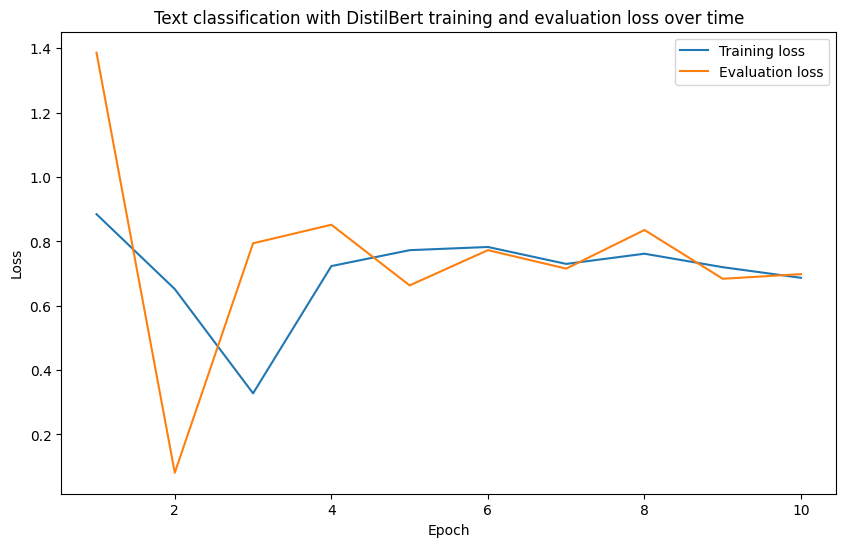

In [57]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

### Pushing our model to the Hugging Face Hub


In [58]:
# Save our model to the Hugging Face Hub
# This will be public, since we set hub_private_repo=False in our TrainingArguments
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model",
     token= HF_token
)
print(f"[INFO] Model successfully uploaded to Hugging Face Hub with at URL: {model_upload_url}")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...bert-base-uncased/model.safetensors:   4%|4         | 11.8MB /  268MB            

  ...bert-base-uncased/training_args.bin:   2%|1         |   101B / 5.43kB            

[INFO] Model successfully uploaded to Hugging Face Hub with at URL: https://huggingface.co/LeDuy23/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/


# Making and evaluating predictions on the test data

Model trained, let's now evaluate it on the test data.

In [59]:
# Preform predictions on the test data

predictions_all = trainer.predict(tokenized_dataset["test"])
predictions_value = predictions_all.predictions
predictions_metrics = predictions_all.metrics
print(f"[INFO] Predictions metrics: {predictions_metrics}")

[INFO] Predictions metrics: {'test_loss': 0.08117161691188812, 'test_accuracy': 1.0, 'test_runtime': 0.0959, 'test_samples_per_second': 521.2, 'test_steps_per_second': 20.848}


In [60]:
import torch
from sklearn.metrics import accuracy_score
# 1 prediction prob
pred_probs = torch.softmax(torch.tensor(predictions_value), dim=1)
# 2 predicted labels
pred_labels = torch.argmax(pred_probs , dim =1 )
# 3 get true labels

true_labels = tokenized_dataset['test']['label']

# 4. Compare predicted labels to true labels to get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")


[INFO] Test accuracy: 100.0%


In [61]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.935738
1,Red brick fireplace with a mantel serving as a...,0,0,0.902414
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.935519
3,Set of mugs hanging on a hook,0,0,0.894643
4,Standing floor lamp providing light next to an...,0,0,0.890715


In [62]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
4,Standing floor lamp providing light next to an...,0,0,0.890715
7,Wooden dresser with a mirror reflecting the room,0,0,0.890839
3,Set of mugs hanging on a hook,0,0,0.894643
15,Set of tools organized in a garage,0,0,0.894780
33,Set of glasses gleaming in a cabinet,0,0,0.895197
22,Two people sitting at a dining room table with...,0,0,0.895722
12,A boy giving his dog a bath in the backyard,0,0,0.896135
43,Set of muffin tins stacked together,0,0,0.896359
23,Yoga mat rolled up and ready in a corner,0,0,0.896635
39,A close-up of a woman practicing yoga in the l...,0,0,0.897000


## Making and inspecting predictions on custom text data

We've seen how our model performs on the test dataset (quite well).

In [63]:
# Setup local model path
local_model_path = "/content/models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Setup Hugging Face model path
huggingface_model_path = "LeDuy23/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

## Discussing ways to make predictions (inference)

When we've loaded our trained model, because of the way we've set it up, there are two main ways to make predictions on custom data

In [64]:
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


### Making predictions with pipeline

In [65]:
import torch
from transformers import pipeline

Batch_size = 32
food_not_food_text_classifier = pipeline(task = "text-classification",
                                         model = local_model_path,
                                         device = DEVICE ,
                                         top_k = 1,
                                         batch_size =  Batch_size)
food_not_food_text_classifier

Device set to use cuda


In [66]:
test_custom_sentence = "I love food"
food_not_food_text_classifier(test_custom_sentence)

[[{'label': 'not_food', 'score': 0.8986173272132874}]]

In [67]:
test_custom_sentence_not_food = "A yellow tractor driving over the hill"
food_not_food_text_classifier(test_custom_sentence_not_food)

[[{'label': 'not_food', 'score': 0.8977431654930115}]]

In [68]:
#use pipeline from model from hugging face
food_not_food_classifier_remote = pipeline(task="text-classification",
                                           model=huggingface_model_path,
                                           batch_size= Batch_size,
                                           device=DEVICE)

food_not_food_classifier_remote("This is some new text about bananas and pancakes and ice cream")


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[{'label': 'food', 'score': 0.9393635988235474}]

### Making multiple predictions at the same time with batch prediction

In [69]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier_remote(sentences)

[{'label': 'not_food', 'score': 0.8779237270355225},
 {'label': 'not_food', 'score': 0.9021148085594177},
 {'label': 'food', 'score': 0.942662239074707},
 {'label': 'food', 'score': 0.5518950819969177},
 {'label': 'food', 'score': 0.6479111909866333},
 {'label': 'not_food', 'score': 0.9024823904037476},
 {'label': 'food', 'score': 0.9426716566085815},
 {'label': 'food', 'score': 0.9393451809883118},
 {'label': 'not_food', 'score': 0.9003756046295166},
 {'label': 'food', 'score': 0.6676944494247437}]

### Time our model across larger sample sizes

In [70]:
import time

sentence_1000 = sentences * 100
len(sentence_1000)

# time how long it takes
print(f"[INFO] number of sentences: {len(sentence_1000)}" )
start_time = time.time()
for sentence in sentence_1000:
  food_not_food_classifier_remote(sentence)
end_time = time.time()
print(f"[INFO] total time: {end_time - start_time}")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] number of sentences: 1000
[INFO] total time: 6.581277847290039


In [71]:
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batches
    food_not_food_classifier_remote(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences: 0.09946 seconds.
[INFO] Avg inference time per sentence: 0.00099464 seconds.

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 0.87335 seconds.
[INFO] Avg inference time per sentence: 0.00087335 seconds.

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 9.16622 seconds.
[INFO] Avg inference time per sentence: 0.00091662 seconds.

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 98.49354 seconds.
[INFO] Avg inference time per sentence: 0.00098494 seconds.



### Making predictions with PyTorch

In [72]:
from transformers import AutoTokenizer
model_path = "LeDuy23/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

sample_text = "I love to eat bacon and eggs for breakfast."

tokenizer = AutoTokenizer.from_pretrained(model_path)
input = tokenizer(sample_text, return_tensors="pt")
input

{'input_ids': tensor([[  101,  1045,  2293,  2000,  4521, 11611,  1998,  6763,  2005,  6350,
          1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [73]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [74]:
import torch

model.eval()
with torch.inference_mode():
  outputs = model(**input)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.0735,  1.7122]]), hidden_states=None, attentions=None)

In [75]:
# convert logits to prediction probability + label
predicted_class_id = outputs.logits.argmax().item()
predicted_probability = torch.softmax(outputs.logits, dim=1).max().item()
print(f"[INFO] text: {sample_text}")
print(f"[INFO] Predicted class ID: {model.config.id2label[predicted_class_id]}")
print(f"[INFO] Predicted probability: {predicted_probability}")

[INFO] text: I love to eat bacon and eggs for breakfast.
[INFO] Predicted class ID: food
[INFO] Predicted probability: 0.9418932795524597


## Putting it all together



1. Import necessary packages (e.g. `datasets`, `transformers.pipeline`, `torch` and more).
2. Setup variables for model training and saving pipeline such as our model name, save directory and dataset name.
3. Create a directory for saving models.
4. Load and preprocess the dataset from Hugging Face Hub using `datasets.load_dataset`.
5. Import a tokenizer with `transformers.AutoTokenizer` and map it to our dataset with `dataset.map`.
6. Set up an evaluation metric with `evaluate` & create a function to evaluate our model's predictions.
7. Import a model with `transformers.AutoModelForSequenceClassification` and prepare it for training with `transformers.TrainingArguments` and `transformers.Trainer`.
8. Train the model on our text dataset by calling `transformers.Trainer.train`.
9. Save the trained model to a local directory.
10. Push the model to the Hugging Face Hub.
11. Evaluate the model on the test data.
12. Test the trained model on a custom sample using `transformers.pipeline` to make sure it works.

In [76]:
# 1. Import necessary packages
import pprint
from pathlib import Path

import numpy as np
import torch

import datasets
import evaluate

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2. Setup variables for model training and saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# 3. Create a directory for saving models
# Note: This will override our existing saved model (if there is one)
print(f"[INFO] Creating directory for saving models: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(path=DATASET_NAME)

# Create mappings from id2label and label2id (adjust these for your target dataset, can also create these programmatically)
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

# Create function to map IDs to labels in dataset
def map_labels_to_number(example):
    example["label"] = label2id[example["label"]]
    return example

# Map preprocessing function to dataset
dataset = dataset["train"].map(map_labels_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Import a tokenizer and map it to our dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast=True)

# Create a preprocessing function to tokenize text
def tokenize_text(examples):
    return tokenizer(examples["text"],
                     padding=True,
                     truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

# 6. Set up an evaluation metric & function to evaluate our model
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels):
    predictions, labels = predictions_and_labels

    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels) # note: use "references" parameter rather than "labels"


# 7. Import a model and prepare it for training
print(f"[INFO] Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
print(f"[INFO] Model loading complete!")

# Setup TrainingArguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    hub_private_repo=False # Note: if set to False, your model will be publically available
)

# Create Trainer instance and train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Train the model on our text dataset
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Save the trained model (note: this will overwrite our previous model, this is ok)
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model",
      token= HF_token
)
print(f"[INFO] Model upload complete, model available at: {model_upload_url}")

# 11. Evaluate the model on the test data
print(f"[INFO] Performing evaluation on test dataset...")
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
pprint.pprint(prediction_metrics)

[INFO] Creating directory for saving models: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: mrdbourke/learn_hf_food_not_food_image_captions
[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

[INFO] Loading model: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3760058368.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[INFO] Model loading complete!
[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.421400,0.108892,0.980000
2,0.042800,0.048167,0.980000
3,0.005900,0.023915,0.980000
4,0.002100,0.001366,1.000000
5,0.001300,0.000969,1.000000
6,0.001000,0.000799,1.000000
7,0.000800,0.000704,1.000000
8,0.000800,0.000650,1.000000
9,0.000700,0.000619,1.000000
10,0.000700,0.000609,1.000000


[INFO] Model training complete, saving model to local path: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...bert-base-uncased/model.safetensors:  13%|#2        | 33.5MB /  268MB            

  ...bert-base-uncased/training_args.bin:  24%|##4       | 1.31kB / 5.43kB            

[INFO] Model upload complete, model available at: https://huggingface.co/LeDuy23/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Performing evaluation on test dataset...


[INFO] Prediction metrics on the test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0006093428237363696,
 'test_runtime': 0.0921,
 'test_samples_per_second': 542.942,
 'test_steps_per_second': 21.718}


In [77]:
food_not_food_classifier = pipeline(task="text-classification",
                                    model=model_save_dir, # can also use model on Hugging Face Hub path
                                    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
                                    top_k=1,
                                    batch_size=32)

food_not_food_classifier("Yo! We just built a food not food sentence classifier model.")

Device set to use cuda


[[{'label': 'not_food', 'score': 0.9990026354789734}]]

## Turning our model into a demo

### Creating a simple function to perform inference


In [82]:
from typing import Dict

def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """

    food_not_food_classifier = pipeline(task="text-classification",
                                        model=local_model_path,
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu", # set the device to work in any environment
                                        top_k=None) # return all possible scores (not just top-1)

    outputs = food_not_food_classifier(text)[0]

    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict



food_not_food_classifier("My lunch today was chicken and salad")


Device set to use cuda


{'food': 0.7705201506614685, 'not_food': 0.2294798642396927}

### Building a small Gradio demo to run locally


In [83]:

import gradio as gr

demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title="Food or Not Food Classifier",
    description="A text classifier to determine if a sentence is about food or not food.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 3. Launch the interface
demo.launch( debug = True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6de3aba9cf09b3d2a0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Device set to use cuda


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://6de3aba9cf09b3d2a0.gradio.live


## Making our demo publicly accessible


In [87]:
from pathlib import Path

demo_dir = Path("../demos")
demo_dir.mkdir(exist_ok=True)

food_not_food_classifier_demo_dir = Path(demo_dir, "food_not_food_text_classifier")
food_not_food_classifier_demo_dir.mkdir(exist_ok=True)

print(f"Created directory: {food_not_food_classifier_demo_dir}")

Created directory: ../demos/food_not_food_text_classifier


### Making an app file

In [88]:
%%writefile ../demos/food_not_food_text_classifier/app.py
# 1. Import the required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define function to use our model on given text
def food_not_food_classifier(text: str) -> Dict[str, float]:
    # Set up text classification pipeline
    food_not_food_classifier = pipeline(task="text-classification",
                                        # Because our model is on Hugging Face already, we can pass in the model name directly
                                        model="LeDuy23/learn_hf_food_not_food_text_classifier-distilbert-base-uncased", # link to model on HF Hub
                                        device="cuda" if torch.cuda.is_available() else "cpu",
                                        top_k=None) # return all possible scores (not just top-1)

    # Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

# 3. Create a Gradio interface with details about our app
description = """
A text classifier to determine if a sentence is about food or not food.
"""

demo = gr.Interface(fn=food_not_food_classifier,
             inputs="text",
             outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
             title="Food or Not Food Text Classifier",
             description=description,
             examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
                       ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 4. Launch the interface
if __name__ == "__main__":
    demo.launch()

Writing ../demos/food_not_food_text_classifier/app.py


### Making a requirements file

In [91]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Writing ../demos/food_not_food_text_classifier/requirements.txt


### Making a README file

In [ ]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
colorFrom: blue
colorTo: yellow
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

# Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

[Source code notebook](https://github.com/LeDuy23/HF_text_classifcation).